In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [45]:
def Pythagore(a, b):
    vect = [b[0]-a[0], b[1]-a[1]]
    return math.sqrt(vect[0]*vect[0]+vect[1]*vect[1])

def EnergieSum(Road, nbPoints):
    energie = 0
    for i in range(nbPoints-1):
        energie += Pythagore(Road[i], Road[i+1])
    energie += Pythagore(Road[0], Road[nbPoints-1])
    return energie

In [55]:
def GeneratePoints(nbPoints, minX, maxX, minY,  maxY):
    points = []
    for _ in range(nbPoints):
        point = [np.random.randint(minX, maxX), np.random.randint(minY, maxY)]
        points.append(point)
    return points

def GeneratePointsInSquare(nbPoints, size):
    return GeneratePoints(nbPoints, -size, size, -size, size)

def plotMap(Road):
    x = [i[0] for i in Road]
    y = [i[1] for i in Road]
    plt.plot(x, y, 'ro')
    x.append(x[0])
    y.append(y[0])
    plt.plot(x, y)#.append(Road[0][0]) .append(Road[0][1])
    #plt.plot(Road, 'ro', Road )
    plt.show()
    

1046765.0148723687


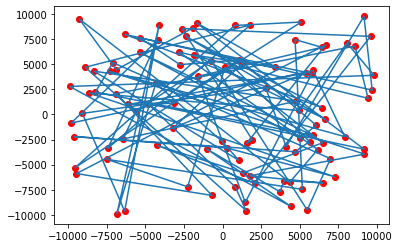

284584.8727440446


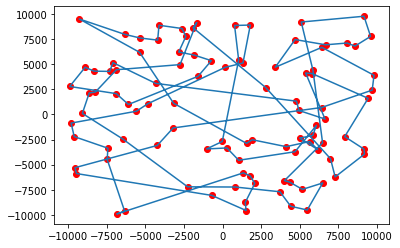

In [76]:
def ModificationElementaire(points, nbPoints):
    rand1 = np.random.randint(0, nbPoints)
    cond = True
    while(cond):
        rand2 = np.random.randint(0, nbPoints)
        cond = rand1 == rand2
    if rand1>rand2 :
        rand1, rand2 = rand2, rand1
    #print(rand1)
    #print(rand2)
    return points[:rand1]+points[rand2:rand2+1]+points[rand1+1:rand2]+points[rand1:rand1+1]+points[rand2+1:]

def Recuit(points, nbPoints, energie, temperature, tempmin = 0.01, multipli = 0.99):
    while(temperature>tempmin):
        newP = ModificationElementaire(points, nbPoints)
        newE = EnergieSum(newP, nbPoints)
        if newE<energie or np.random.random() < math.exp(-(newE-energie)/temperature):
            energie = newE
            points = newP
        temperature = temperature*multipli
    return points, energie

np.random.seed(2)


nbPoints = 100
points = GeneratePointsInSquare(nbPoints, 10000)

energie = EnergieSum(points, nbPoints)
print(energie)
plotMap(points)

points, energie = Recuit(points, nbPoints, energie, 200.0, 0.001, 0.999)
print(energie)
plotMap(points)